# **AP157 Module C Lab Assignment**

## Module C2: Monte Carlo Methods

_Instructions_: Answer each part of the assignment as completely as you can. Discuss **all** your code and results as clearly and concisely as possible.

_Scoring Criteria_: 50% - *correctness of code*; 50% - *discussion of the code and results*. Maximum score is **100 points**.

_Credits_: This lab assignment is based on work by Dr. Reyes in collaboration with Gene Belinario and Dr. Reginald Bernardo.

### Student Information

_Full Name (Last Name, First Name)_: Mendoza, Genesis Adam \
_Student No._: 2019-05415 \
_Section_: THY-TX-2

### Submission Information

_Date and Time Submitted (most recent upload)_: 23/05/2024 - 11:47 PM

**HONOR PLEDGE** I affirm that I have upheld the highest principles of honesty and integrity in my academic work and that this lab assignment is my own work.

**Sign here with your full name: GENESIS ADAM D. MENDOZA**

### Grading Information (c/o Instructor)

TOTAL SCORE: **[]**/100

Score breakdown:
* Part 1 - []/20
* Part 2 - []/20
* Part 3 - []/30
* Part 4 - []/30

_Date and Time Scored (MM/DD/YYYY HH:MM AM/PM):_

In this lab assignment, you will generate constraints on cosmological parameters, the Hubble parameter H_0 and matter density Omega_m,0, from (synthetic) Hubble diagram data points from gravitational-wave (GW) sirens observed from 3 GW observatories: LIGO, LISA, and Einstein Telescope (ET).

The datasets are in the Google Drive "Datasets" Folder under "AP157_moduleC2" subfolder: https://drive.google.com/drive/folders/1UnK1AggxdsjtG3PoOcyXfpahBcWjOBzj?usp=drive_link.

Read in the 3 datasets from the CSV files: LIGO.csv, LISA.csv, ET.csv. The columns are redshift (z), luminosity distance (dL), and error in the luminosity distance (err). The distances are in units of Gpc (giga-parsecs).

Load the data into variable names: zLIGO, dLLIGO, errLIGO, zLISA, dLLISA, errLISA, and zET, dLET, and errET, respectively. Note that these variable names will be used in later parts of the code, so you have to use these names for compatibility.

In [9]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import emcee as emcee
import corner

data_path = '..//datasets//'
LIGO = pd.read_csv(data_path+'LIGO.csv')
zLIGO = LIGO['zLIGO']
dlLIGO = LIGO['dlLIGO']
errLIGO = LIGO['errLIGO']

LISA = pd.read_csv(data_path+'LISA.csv')
zLISA = LISA['zLISA']
dlLISA = LISA['dlLISA']
errLISA = LISA['errLISA']

ET = pd.read_csv(data_path+'ET.csv')
zET = ET['zET']
dlET = ET['dlET']
errET = ET['errET']

By the end of the lab assignment, you will generate constraints on the cosmological parameters H_0 and omega_m,0 for 3 samples: LIGO only, LIGO+LISA, and LIGO+LISA+ET (combined). You will generate a corner plot to visualize these constraints similar to the figure here: https://drive.google.com/file/d/18H7GPlox4ijS9qFbk1rHo-NW5N_Nsfer/view?usp=drive_link

#### PART 1 - Generate Hubble Diagram *(20 points)*

Make a Hubble diagram plot-- with luminosity distance (d_L) in the vertical axis and redshift (z) in the horizontal axis. Show the errors in d_L as error bars.

Plot GW sirens from the 3 observatories in the same plot and include a legend. Briefly describe the difference between the samples from the 3 observatories.

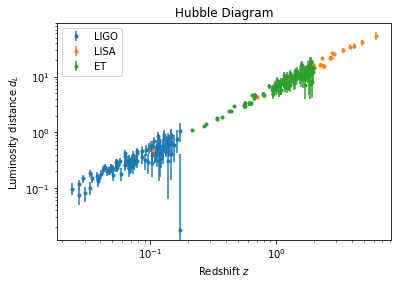

In [10]:
plt.scatter(zLIGO, dlLIGO, s = 0.1)
plt.errorbar(zLIGO,dlLIGO, yerr=errLIGO, fmt='.', label = 'LIGO')
plt.scatter(zLISA, dlLISA, s = 0.1)
plt.errorbar(zLISA,dlLISA, yerr=errLISA, fmt='.', label = 'LISA')
plt.scatter(zET, dlET, s = 0.1)
plt.errorbar(zET,dlET, yerr=errET, fmt='.', label = 'ET')
plt.xlabel('Redshift $z$')
plt.ylabel('Luminosity distance $d_L$')
plt.title('Hubble Diagram')
plt.xscale('log')
plt.yscale('log')
plt.legend()
plt.show()

The three observatories concerns themselves with different luminosity distances.

#### PART 2 - Define likelihood functions *(20 points)*

In this analysis, we will assume the cosmological model to be flat LambdaCDM universe. This is given by the `FlatLambdaCDM' model from the astropy.cosmology package. In particular, we use the model for the luminosity distance as a function of redshift, which is encoded in the luminosity_distance function.

Below, define the chi-square and likelihood function to be used for the LIGO only and the LIGO+LISA dataset. You are asked to define the analogous functions for the LIGO+LISA+ET dataset. Note that the likelihood for the combined dataset is simply the sum of the likelihoods for the individual datasets.




In [11]:
from astropy.cosmology import FlatLambdaCDM

In [12]:
def chi2LIGO_lcdm(H0, Om0):
    cosmo = FlatLambdaCDM(H0=H0, Om0=Om0, Tcmb0=2.725)      # define cosmological model
    model = np.array(cosmo.luminosity_distance(zLIGO)/1000) # converted from Gpc to Mpc units
    dev = (model - np.array(dlLIGO))/np.array(errLIGO)      # deviations between model and data
    chi2 = sum(dev**2)
    return chi2

def llikeLIGO_lcdm(H0, Om0):
    if (H0 < 0) or (Om0 < 0) or (Om0 > 1):
        return -np.inf                        # return inf if outside priors
    else:
        return -0.5*chi2LIGO_lcdm(H0, Om0)

# LIGO + LISA
def chi2LISA_lcdm(H0, Om0):
    cosmo = FlatLambdaCDM(H0=H0, Om0=Om0, Tcmb0=2.725)
    model = np.array(cosmo.luminosity_distance(zLISA)/1000)
    dev = (model - np.array(dlLISA))/np.array(errLISA)
    chi2 = sum(dev**2)
    return chi2

def llikeLIGOLISA_lcdm(H0, Om0):
    if (H0 < 0) or (Om0 < 0):
        return -np.inf
    else:
        return -0.5*(chi2LIGO_lcdm(H0, Om0) + chi2LISA_lcdm(H0, Om0))

# LIGO + LISA + ET
def chi2ET_lcdm(H0, Om0):
    cosmo = FlatLambdaCDM(H0=H0, Om0=Om0, Tcmb0=2.725)
    model = np.array(cosmo.luminosity_distance(zET)/1000)
    dev = (model - np.array(dlET))/np.array(errET)
    chi2 = sum(dev**2)
    return chi2

def llikeLIGOLISAET_lcdm(H0, Om0):
    if (H0 < 0) or (Om0 < 0):
        return -np.inf
    else:
        return -0.5*(chi2LIGO_lcdm(H0, Om0) + chi2LISA_lcdm(H0, Om0) + chi2ET_lcdm(H0, Om0))

#### PART 3 - Perform MCMC runs *(30 points)*

Use the emcee library to set up and perform MCMC runs for the 3 samples: LIGO only, LIGO+LISA, and LIGO+LISA+ET combined.

You can use number of walkers (nwalkers) of 6 and number of iterations (niter) of 5,000 and number of burn-in samples (nburn) of 100.


In [13]:
# Set up MCMC sampler
n_walkers = 6
n_iter = 5000
n_burn = 100
n_dim = 2 #we're finding two unknowns

#We will explicitly write our posterior to have a vector (params) as an input.

def ln_posterior_LIGO(params):
    H0, Om0 = params
    return llikeLIGO_lcdm(H0, Om0)

def ln_posterior_LIGOLISA(params):
    H0, Om0 = params
    return llikeLIGOLISA_lcdm(H0, Om0)

def ln_posterior_LIGOLISAET(params):
    H0, Om0 = params
    return llikeLIGOLISAET_lcdm(H0, Om0)

# The initial guesses for H_0 and Omega_0, respectively, are

init_guess = [70, 0.4]

# Initialize walkers on a tiny gaussian ball.

init_LIGO = [init_guess + 10**-4 * np.random.randn(2) for i in range(n_walkers)]
init_LIGOLISA = [init_guess + 10**-4 * np.random.randn(2) for i in range(n_walkers)]
init_LIGOLISAET = [init_guess + 10**-4 * np.random.randn(2) for i in range(n_walkers)]

LIGO_samp = emcee.EnsembleSampler(n_walkers, n_dim, ln_posterior_LIGO)
LIGO_samp.run_mcmc(init_LIGO, n_iter, progress = True)

LIGOLISA_samp = emcee.EnsembleSampler(n_walkers, n_dim,ln_posterior_LIGOLISA)
LIGOLISA_samp.run_mcmc(init_LIGOLISA, n_iter, progress = True)

LIGOLISAET_samp = emcee.EnsembleSampler(n_walkers, n_dim, ln_posterior_LIGOLISAET)
LIGOLISAET_samp.run_mcmc(init_LIGOLISAET, n_iter, progress = True)

  4%|▎         | 178/5000 [00:01<00:42, 114.66it/s]


KeyboardInterrupt: 

**LIGO time series**

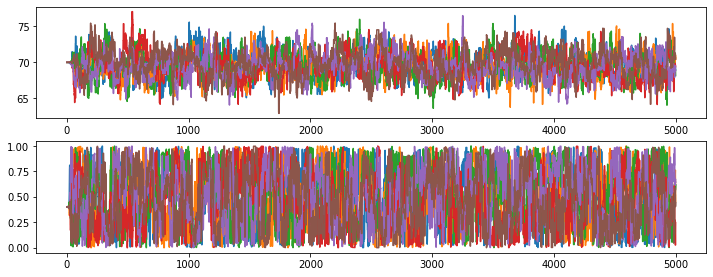

In [ ]:
plt.figure(figsize=(12, 7))

plt.subplot(3, 1, 1)
plt.plot(LIGO_samp.get_chain()[:,:,0])

plt.subplot(3, 1, 2)
plt.plot(LIGO_samp.get_chain()[:,:,1])

plt.show()

LIGO walkers seem to move randomly. It doesn't converge to anything.

**LIGO + LISA time series**

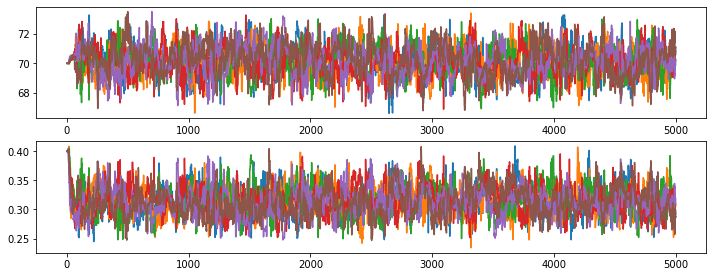

In [ ]:
plt.figure(figsize=(12, 7))

plt.subplot(3, 1, 1)
plt.plot(LIGOLISA_samp.get_chain()[:,:,0])

plt.subplot(3, 1, 2)
plt.plot(LIGOLISA_samp.get_chain()[:,:,1])

plt.show()

**LIGO + LISA + ET time series**

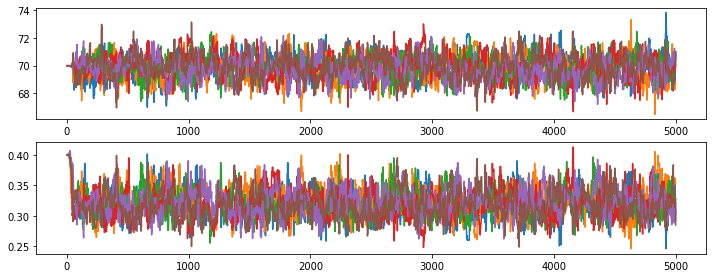

In [ ]:
plt.figure(figsize=(12, 7))

plt.subplot(3, 1, 1)
plt.plot(LIGOLISAET_samp.get_chain()[:,:,0])

plt.subplot(3, 1, 2)
plt.plot(LIGOLISAET_samp.get_chain()[:,:,1])

plt.show()

After several steps, it seems like the plots are pretty much 'stabilized'. We will discard the first `n_burn` values.

In [ ]:
samples_LIGO = LIGO_samp.get_chain(discard = n_burn, flat = True)
samples_LIGOLISA = LIGOLISA_samp.get_chain(discard = n_burn, flat = True)
samples_LIGOLISAET = LIGOLISAET_samp.get_chain(discard = n_burn, flat = True)

Visualizing, we get

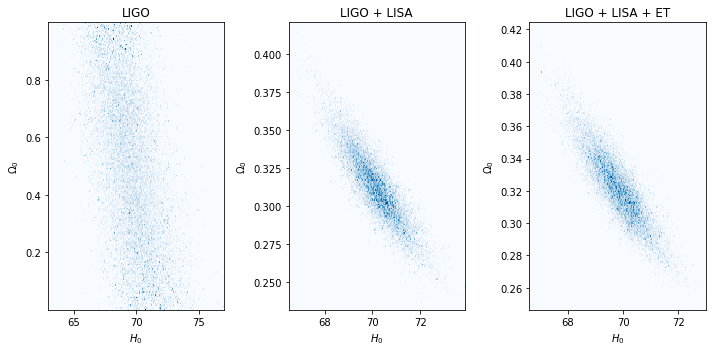

In [ ]:
hist_bins = 200

plt.figure(figsize=(10, 5))

plt.subplot(1, 3, 1)
plt.hist2d(samples_LIGO[:, 0], samples_LIGO[:, 1], cmap='Blues', bins = hist_bins)
plt.xlabel('$H_0$')
plt.ylabel('$\Omega_0$')
plt.title('LIGO')

plt.subplot(1, 3, 2)
plt.hist2d(samples_LIGOLISA[:, 0], samples_LIGOLISA[:, 1], cmap='Blues', bins = hist_bins)
plt.xlabel('$H_0$')
plt.ylabel('$\Omega_0$')
plt.title('LIGO + LISA')

plt.subplot(1, 3, 3)
plt.hist2d(samples_LIGOLISAET[:, 0], samples_LIGOLISAET[:, 1],  cmap='Blues', bins = hist_bins)
plt.xlabel('$H_0$')
plt.ylabel('$\Omega_0$')
plt.title('LIGO + LISA + ET')

plt.tight_layout()
plt.show()

#### PART 4 - Generate corner plot to visualize the constraints *(30 points)*

Overlay the results for the 3 samples for easy comparison. Your plot should resemble the figure here: https://drive.google.com/file/d/18H7GPlox4ijS9qFbk1rHo-NW5N_Nsfer/view?usp=drive_link

Briefly describe the difference between the constraints obtained from the different samples.

<Figure size 6000x6000 with 0 Axes>

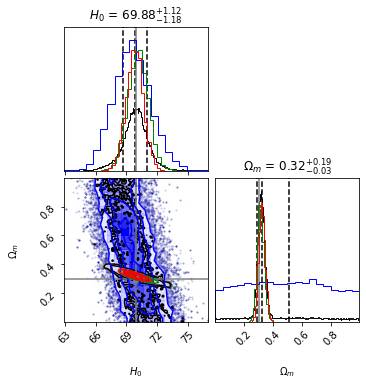

In [ ]:
all_samples = np.vstack([samples_LIGO, samples_LIGOLISA, samples_LIGOLISAET])

# We can generate the corner plot for LIGO
plt.figure(figsize=(15,15), dpi = 400)
fig = corner.corner(all_samples, labels=[r'$H_0$', r'$\Omega_m$'], bins=hist_bins, color='black', truths= [70, 0.3], truth_color='grey',quantiles=[0.16, 0.5, 0.84], show_titles=True, title_kwargs={"fontsize": 12}, smooth = True, fill_contours = True)

# Nest, we can overlay results for each sample
corner.corner(samples_LIGO, fig=fig, color='blue')
corner.corner(samples_LIGOLISA, fig=fig, color='green')
corner.corner(samples_LIGOLISAET, fig=fig, color='red')

plt.savefig("..//images//cornerplot.pdf")
plt.show()

LIGO doesn't provide much information when it comes to constraining $\Omega_m$, but it does an 'okay' job in terms of $H_0$. Incorporating LISA and ET makes it much more precise in determining the values of both $\Omega_m$ and $H_0$.